# Bank Risk and Deposit Project  

This project explores how interest rates and other variables affect the deposit amounts in corporate savings accounts.   
In this dataset, there are not many trends founded because of too artificial. But in general I build models and choose the best one that has good scores in the metrics such as RSME and R2.  The feature of importace are sometimes variable because each model has specific characteristics.   

In [ ]:
! pip install lime

In [ ]:
!pip install tensorflow scikit-learn pandas numpy matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from lime.lime_tabular import LimeTabularExplainer
import shap

In [ ]:
#create a dataset with synthetic data

# setting parameter
n_corporates = 1000  # num of companies
n_months = 36  # data for 36months
np.random.seed(42)

# create corporate ID
corporate_ids = np.arange(1, n_corporates + 1)

# initiate dataframe
data = []

# generate synthetic data for corporate saving accounts
for corporate_id in corporate_ids:
    balance = np.random.uniform(10000, 1000000)  # initial amount ($10K〜$1M）
    previous_interest_rate = np.random.uniform(0.3, 5.0)  # interest rate previous month
    previous_deposit_amount = balance  # deposit amount in the previous month（initial）

    # initial setting for cash flow
    revenue = np.random.uniform(100000, 500000)  # initial revenue（$100K〜$500K）
    expenses = revenue * np.random.uniform(0.4, 0.6)  # initial expenses（40〜60% of revenue）
    investments = np.random.uniform(50000, 100000)  # initial investments（$50K〜$100K）
    loan_repayment = np.random.uniform(20000, 50000)  # initial loan repayment（$20K〜$50K）

    for month in range(n_months):
        date = pd.to_datetime(f'2023-{(month % 12) + 1:02d}-01') + pd.DateOffset(months=(month // 12) * 12)

        # interest rate current month
        interest_rate = np.random.uniform(0.3, 5.0)

        # fluctuate interest rate（from previous month）
        interest_rate_change = interest_rate - previous_interest_rate

        # random fluctuations of revenue, expenses, investments, loan repayment
        revenue_change = revenue * np.random.uniform(-0.05, 0.05)  # fluctuations of revenue（±5%）
        expense_change = expenses * np.random.uniform(-0.05, 0.05)  # fluctuations of expenses（±5%）
        investment_change = np.random.uniform(-10000, 20000)  # fluctuations of investoments（±$10K〜$20K）
        loan_repayment_change = np.random.uniform(-5000, 10000)  # fluctuations of loan repayments（±$5K〜$10K）

        # update revenue, expenses, investments, loan repayment
        revenue += revenue_change
        expenses += expense_change
        investments += investment_change
        loan_repayment += loan_repayment_change

        # calculation of cashflow
        net_cash_flow = revenue - expenses - investments - loan_repayment

        # the assumption that deposits are likely to increase when preparedness increases
        deposit_incentive = 0  # no incentive at the beginning
        if interest_rate_change > 0:
            deposit_incentive = np.random.uniform(0.05, 0.2) * (balance * interest_rate_change)  # increasing amount with interest rate

        # deposit fluctuation (random fluctuation from -50K to +200K) plus interest rate incentives and cash flow
        deposit_change = np.random.uniform(-50000, 200000) + deposit_incentive + net_cash_flow
        balance += deposit_change

        if balance < 0:
            balance = 0  # balance cannot go below zero

        # determine the type of transactions
        transaction_type = 'deposit' if deposit_change >= 0 else 'withdraw'

        # set as saving account
        account_type = 'corporate_savings'

        # adding data
        data.append([corporate_id, date, previous_deposit_amount, previous_interest_rate,
                     deposit_change, balance, interest_rate, account_type,
                     transaction_type, interest_rate_change, revenue, expenses, investments, loan_repayment, net_cash_flow])

        # set the current interest rate and deposit amount as the previous month's data for the next month
        previous_interest_rate = interest_rate
        previous_deposit_amount = balance

# create DataFrame
df = pd.DataFrame(data, columns=[
    'corporate_id', 'date', 'previous_deposit_amount', 'previous_interest_rate',
    'deposit_change', 'balance_after_transaction', 'current_interest_rate',
    'account_type', 'transaction_type', 'int_rate_change',
    'revenue', 'expenses', 'investments', 'loan_repayment', 'net_cash_flow'
])
pd.set_option('display.float_format', '{:.2f}'.format)
df.head()



,corporate_id,date,previous_deposit_amount,previous_interest_rate,deposit_change,balance_after_transaction,current_interest_rate,account_type,transaction_type,int_rate_change,revenue,expenses,investments,loan_repayment,net_cash_flow
0,1,2023-01-01,380794.72,4.77,304413.03,685207.75,0.57,corporate_savings,deposit,-4.20,407180.89,206213.61,69043.11,19988.60,111935.57
1,1,2023-02-01,685207.75,0.57,490690.53,1175898.28,4.21,corporate_savings,deposit,3.64,395467.89,199652.41,64545.24,19552.24,111718.00
2,1,2023-03-01,1175898.28,4.21,188096.74,1363995.02,1.67,corporate_savings,deposit,-2.54,399891.31,192454.81,63309.58,20047.66,124079.25
3,1,2023-04-01,1363995.02,1.67,547862.64,1911857.67,3.99,corporate_savings,deposit,2.32,387881.52,192728.76,71082.02,15744.42,108326.32
4,1,2023-05-01,1911857.67,3.99,77360.59,1989218.26,0.61,corporate_savings,deposit,-3.38,405292.96,201702.83,85333.94,15313.63,102942.56


In [ ]:
df.shape

(36000, 15)

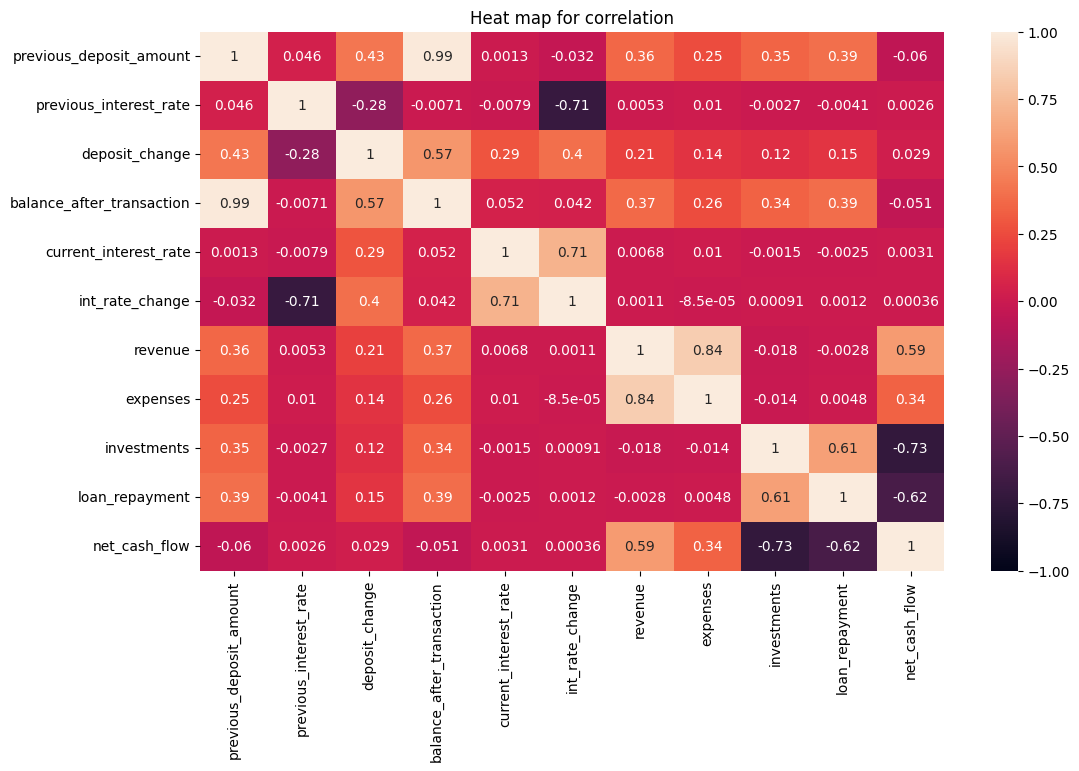

In [ ]:
plt.figure(figsize = (12, 7))
sns.heatmap(df.drop(['corporate_id', 'date','account_type', 'transaction_type'], axis = 1).corr(), annot = True, vmin = -1, vmax = 1)
plt.title('Heat map for correlation')
plt.show()

**Insights**   
This visualizaion shows how each avriable correlated others.    

1, Strong positive correlation (correlation of +0.7 or higher): This indicates that the two variables move in almost the same direction. For example, if both revenue and expenses are high, we would expect a strong positive correlation between them as 0.84.   

2, Strong negative correlation (correlation of -0.7 or lower): This suggests that the two variables move in opposite directions. For instance, investments and net_cash_flow may exhibit a negative correlation as -0.73 (the higher the investments, the lower the net_cash_flow amount).   

3, Correlation close to 0: This means there is little to no relationship between the two variables. For example, there might be little to no correlation between deposit amounts and transaction types.  

4, Pairs worth paying attention to: Focus on pairs of variables with high correlations to gain business insights. For instance, if there is a strong correlation between interest rates and deposit amounts, this might suggest that interest rate policies have an impact on deposit amounts.  

In [ ]:
correlation = df[["deposit_change", "int_rate_change"]].corr(method="pearson")
print(correlation)

                 deposit_change  int_rate_change
deposit_change             1.00             0.40
int_rate_change            0.40             1.00


In [ ]:
correlation_interest_balance = df[["current_interest_rate", "balance_after_transaction"]].corr(method="pearson")
print(correlation_interest_balance)

                           current_interest_rate  balance_after_transaction
current_interest_rate                       1.00                       0.05
balance_after_transaction                   0.05                       1.00


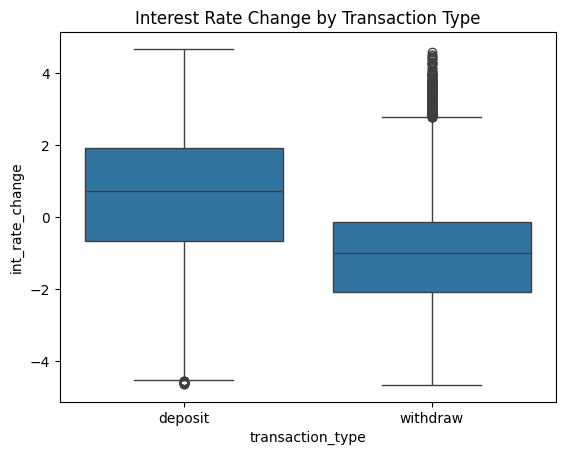

In [ ]:
# check the distribution of transaction types (deposits, withdrawals) by interest rate fluctuations
sns.boxplot(data=df, x='transaction_type', y='int_rate_change')
plt.title('Interest Rate Change by Transaction Type')
plt.show()

**Insights**  
When the interest rate increases, clients tend to deposit more funds. Conversely, when the interest rate decreases, they tend to withdraw more funds.

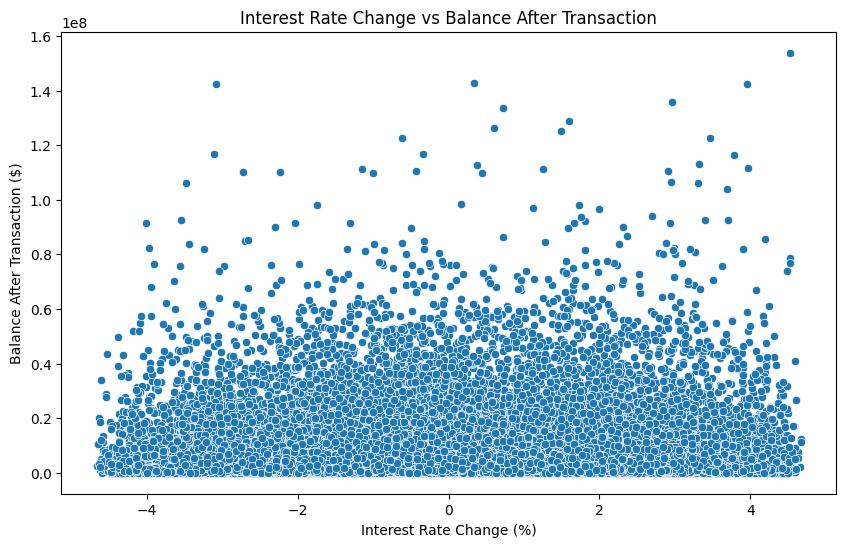

In [ ]:
#Visualize the relationship between interest rates and deposit amounts using a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='int_rate_change', y='balance_after_transaction')
plt.title('Interest Rate Change vs Balance After Transaction')
plt.xlabel('Interest Rate Change (%)')
plt.ylabel('Balance After Transaction ($)')
plt.show()

**Insights**  
There aren’t many clear trends, but when interest rates rise, the number of outliers increases, and clients tend to deposit larger amounts.

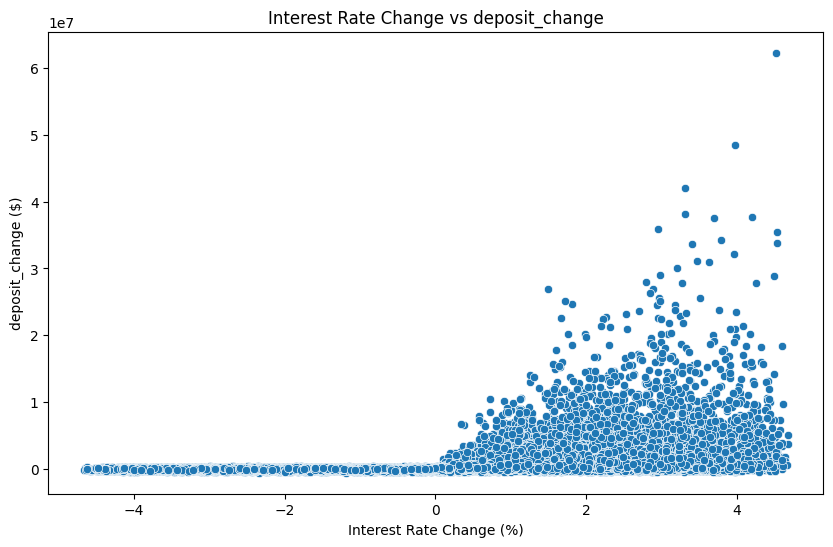

In [ ]:
#Visualize the relationship between interest rates and deposit change using a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='int_rate_change', y='deposit_change')
plt.title('Interest Rate Change vs deposit_change')
plt.xlabel('Interest Rate Change (%)')
plt.ylabel('deposit_change ($)')
plt.show()

**Insights**  
When the interest rate increases, the deposit amount also tends to increase.  

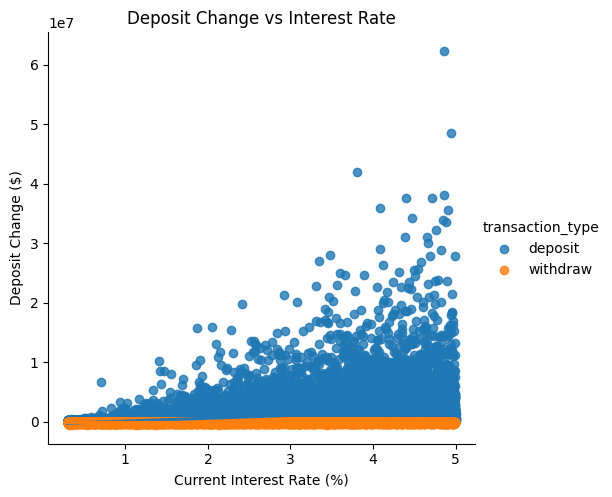

In [ ]:
#relationship between interest rates and deposit amount fluctuations
sns.lmplot(data=df, x='current_interest_rate', y='deposit_change', hue='transaction_type')
plt.title('Deposit Change vs Interest Rate')
plt.xlabel('Current Interest Rate (%)')
plt.ylabel('Deposit Change ($)')
plt.show()

**Insights**   
While an increase in interest rates encourages clients to deposit more funds, the amount of withdrawals remains the same.  

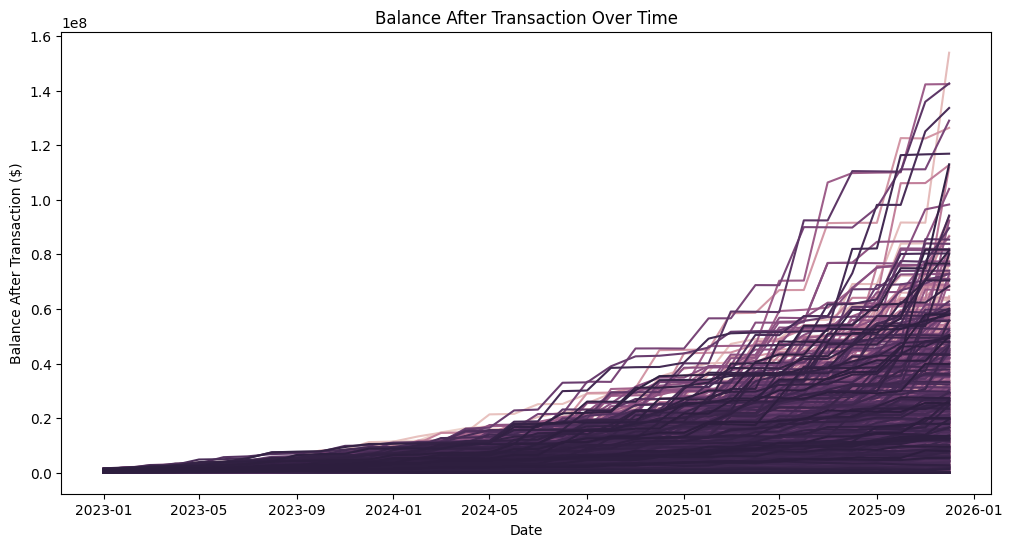

In [ ]:
#displays monthly deposit balance trends for each corporation
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='balance_after_transaction', hue='corporate_id', legend=None)
plt.title('Balance After Transaction Over Time')
plt.xlabel('Date')
plt.ylabel('Balance After Transaction ($)')
plt.show()

#Granger causality tests

In [ ]:
#granger causality test (up to 3 lags)
grangercausalitytests(df[["int_rate_change","deposit_change"]], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3297  , p=0.0023  , df_denom=35996, df_num=1
ssr based chi2 test:   chi2=9.3305  , p=0.0023  , df=1
likelihood ratio test: chi2=9.3293  , p=0.0023  , df=1
parameter F test:         F=9.3297  , p=0.0023  , df_denom=35996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.6377  , p=0.0013  , df_denom=35993, df_num=2
ssr based chi2 test:   chi2=13.2773 , p=0.0013  , df=2
likelihood ratio test: chi2=13.2748 , p=0.0013  , df=2
parameter F test:         F=6.6377  , p=0.0013  , df_denom=35993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.9131  , p=0.0021  , df_denom=35990, df_num=3
ssr based chi2 test:   chi2=14.7420 , p=0.0021  , df=3
likelihood ratio test: chi2=14.7390 , p=0.0021  , df=3
parameter F test:         F=4.9131  , p=0.0021  , df_denom=35990, df_num=3


{np.int64(1): ({'ssr_ftest': (np.float64(9.329747736674285),
    np.float64(0.002256281342601778),
    np.float64(35996.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(9.330525302048493),
    np.float64(0.0022536773985866354),
    np.int64(1)),
   'lrtest': (np.float64(9.329316328716232),
    np.float64(0.0022551647762425694),
    np.int64(1)),
   'params_ftest': (np.float64(9.329747737613225),
    np.float64(0.002256281341446884),
    np.float64(35996.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(6.637704877872367),
    np.float64(0.0013116346750304403),
    np.float64(35993.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(13.277253921242991),
    np.float64(0.0013088230763031686),
    np.int64(2)),
   'lrtest': (np.float64(13.27480597779504),
    np.float64(0.0013104260195187217),
    np.int64(2)),
   'params_ftest': (np.float64(6.637704811183296),
    np.float64(0.0013116347624752074),
    np.float64(35993.0),
    2.0)},
   array([[0., 

**Insights**  
Insights from Granger Causality Test Results
The Granger causality test examines whether changes in interest rates (int_rate_change) can predict changes in corporate deposit amounts (deposit_change). The test was conducted with lags of 1, 2, and 3 to assess how past values of the interest rate impact future deposit amounts.

1️⃣ Lag 1 Results:
F-test: F = 9.3297, p = 0.0023

Chi-squared test: chi2 = 9.3305, p = 0.0023

Likelihood ratio test (LR): chi2 = 9.3293, p = 0.0023

✅ Interpretation:
The p-value of 0.0023 indicates that the null hypothesis (that changes in interest rates do not Granger-cause changes in deposit amounts) is rejected at lag 1.
➡️ Conclusion: There is strong evidence that changes in interest rates influence deposit changes with a 1-month lag.

2️⃣ Lag 2 Results:
F-test: F = 6.6377, p = 0.0013

Chi-squared test: chi2 = 13.2773, p = 0.0013

Likelihood ratio test (LR): chi2 = 13.2748, p = 0.0013

✅ Interpretation:
The p-value of 0.0013 further confirms that changes in interest rates significantly Granger-cause changes in deposit amounts when considering a 2-month lag.
➡️ Conclusion: The relationship is still statistically significant with a 2-month lag, indicating that deposit changes are influenced not only by the previous month’s interest rate changes but also by those from two months ago.

3️⃣ Lag 3 Results:
F-test: F = 4.9131, p = 0.0021

Chi-squared test: chi2 = 14.7420, p = 0.0021

Likelihood ratio test (LR): chi2 = 14.7390, p = 0.0021

✅ Interpretation:
The p-value of 0.0021 suggests that even with a 3-month lag, changes in interest rates continue to Granger-cause changes in deposit amounts.
➡️ Conclusion: The effect of interest rate changes on deposit amounts persists up to 3 months, although the strength of the relationship appears to weaken slightly with longer lags.

📊 Summary of Findings:
Across all three lags (1, 2, and 3), the p-values remain below the 0.05 significance threshold, indicating that changes in interest rates consistently Granger-cause changes in corporate deposit amounts.

The strongest impact is observed at lag 1 (p = 0.0023), but the effect remains statistically significant even at lag 3 (p = 0.0021).

This suggests that corporate deposit changes respond relatively quickly to interest rate changes, with the influence persisting over a 3-month period.

🎯 Implication for Business Decisions:
Deposit Management Strategy: Financial institutions should monitor interest rate changes closely, as their effects on corporate deposit balances may be observable within 1-3 months.

In [ ]:
X = df[['previous_deposit_amount', 'date', 'previous_interest_rate', 'deposit_change', 'current_interest_rate', 'transaction_type', 'int_rate_change', 'revenue', 'expenses', 'investments', 'loan_repayment', 'net_cash_flow']]
y = df['balance_after_transaction']

In [ ]:
X = pd.get_dummies(X, drop_first = True)

In [ ]:
X['date'] = (X['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("X train: ",X_train.shape)
print("X test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

X train:  (28800, 12)
X test:  (7200, 12)
y train:  (28800,)
y test:  (7200,)


# Regression model in Deep learning

In [ ]:
#scale with MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#y (target) is also scaled
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

#improved model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
#model.add(Dense(64, input_dim=10, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

#compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mean_squared_error', metrics=['mean_squared_error'])

#callback Settings
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

#training the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=500,
    batch_size=128,
    callbacks=[early_stopping, lr_reduction],
    verbose=1
)

#predicting and descaling the test data
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

#evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"✅ Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"☑️ R-squared (R2): {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - learning_rate: 1.0000e-04
Epoch 2/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - learning_rate: 1.0000e-04
Epoch 3/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - learning_rate: 1.0000e-04
Epoch 4/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - learning_rate: 1.0000e-04
Epoch 5/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - learning_rate: 1.0000e-04
Epoch 6/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.00

📊 Insights and Analysis of Model Performance
The neural network model has been trained and evaluated successfully to predict deposit changes (y_pred) based on various features (X_test). Below is an in-depth analysis of the results.

🎯 1. Model Overview:
Model Architecture:

Input Layer: 64 neurons, ReLU activation

Hidden Layer 1: 64 neurons, ReLU + Dropout (30%)

Hidden Layer 2: 32 neurons, ReLU + Dropout (30%)

Hidden Layer 3: 16 neurons, ReLU

Output Layer: 1 neuron, Linear activation (for regression)

Optimizer & Loss:

Optimizer: Adam with a learning rate of 0.0001 (adaptive learning rate)

Loss function: Mean Squared Error (MSE), optimized for minimizing error in continuous predictions.

Callbacks:

EarlyStopping: Stops training if no improvement is detected after 20 consecutive epochs (patience).

ReduceLROnPlateau: Reduces the learning rate by 50% if no improvement occurs after 10 epochs, preventing overfitting and speeding up convergence.

📊 2. Model Evaluation Results:   
✅ Root Mean Squared Error (RMSE):  


RMSE=1,960,852.28  
RMSE quantifies the average error in the model’s predictions.  

An RMSE of approximately $1.96 million suggests that the predicted deposit changes deviate from the actual values by around this amount on average.

☑️ R-squared (R²):

R
2
=
0.9680   

R² (coefficient of determination) measures how well the model explains the variance in the target variable.

With R² = 0.9680, the model explains about 96.8% of the variance in the target variable, indicating a highly accurate model.

📈 3. Key Insights:  
Strong Predictive Power:  
The high R² value suggests that the model captures most of the variance in the deposit changes, demonstrating strong predictive capability.

Low Prediction Error:
Despite the high RMSE value (~$1.96 million), this may be acceptable if the target variable (deposit_change) has a wide range or large scale. The RMSE should be interpreted relative to the magnitude of the data.

Effective Regularization:
The use of Dropout layers (30%) has helped prevent overfitting, as indicated by the model’s consistent validation loss and the high R² value on test data.

Efficient Learning Rate Adaptation:
ReduceLROnPlateau dynamically reduced the learning rate during training, ensuring that the model converged efficiently.


🚀 4. Business Implications:  
Deposit Forecasting: The model can be used for predicting future deposit changes, enabling more precise liquidity management.

Policy Adjustments: High sensitivity of deposits to interest rate changes can inform interest rate policy adjustments to optimize deposit retention.

Risk Management: Accurate prediction of deposit fluctuations can help manage risks associated with sudden inflows or outflows of corporate funds.

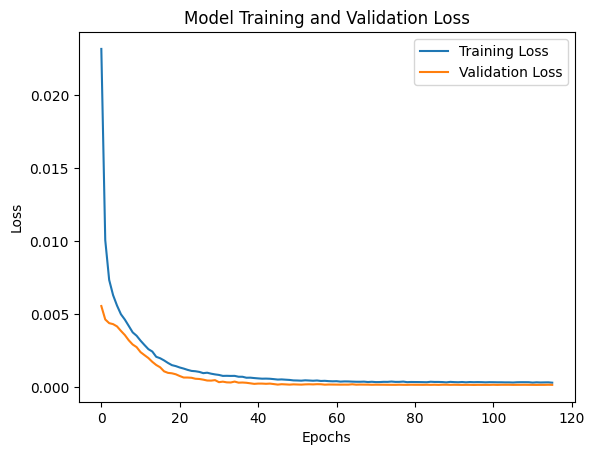

In [ ]:
# loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Insights**    
Good model. The loss is decreasing for both the training and test sets, which indicates that the model is effectively learning the patterns from the training data and generalizing them well to the test data. If overfitting were happening, you would see the training loss continue to decrease while the validation loss starts to increase over time.  

# Check part of the feature importance with Lime

In [ ]:
#convert to NumPy array
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
X_test_np = X_test.values if hasattr(X_test, 'values') else X_test

#creating a LIME explainer
explainer = LimeTabularExplainer(
    X_train_np,
    feature_names=X_train.columns,
    mode='regression',
    training_labels=y_train,
    random_state=42
)

#instance description
exp = explainer.explain_instance(
    X_test_np[0],  #first line of the instance
    lambda x: model.predict(x).reshape(-1),  #prediction functions
    num_features=5
)

# Notebook
exp.show_in_notebook()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


**Insights**  
📊 Insights from LIME Explanation:  
LIME (Local Interpretable Model-agnostic Explanations) is a method used to explain individual predictions made by complex machine learning models. It approximates the behavior of the model locally using interpretable models (like linear models), which makes it easier to understand how specific features contribute to a given prediction.  

🧩 Key Features Influencing the Prediction:  
The explanation shows the top 5 features influencing the predicted deposit change, along with their corresponding values:  

-previous_deposit_amount: 2,677,235.40 (Negative impact)  

The previous deposit amount is quite high, but it has a negative influence on the predicted deposit change.  

-deposit_change: 124,503.52 (Negative impact)  

The previous deposit change is also positive, but it is negatively correlated with the predicted change in this case. This may suggest that large recent deposits do not necessarily lead to further growth in deposits.  

-expenses: 200,891.30 (Positive impact)  

Expenses are high, and their positive influence indicates that higher expenses may be associated with an increase in deposit changes, potentially due to adjustments made for covering the expenses.  

-investments: 121,155.10 (Positive impact)  

Similarly, investments are also a positive influence on deposit changes. Investments may be correlated with revenue generation, potentially boosting future deposits.  

-net_cash_flow: -5,565.66 (Negative impact)  

Net cash flow is negative, which typically indicates that there is less money coming in than going out, and this has a negative influence on the deposit change. A negative cash flow usually signals financial distress or outflow, which can reduce available deposits.  

📈 Overall Interpretation of the Instance:  
The model's prediction of a negative deposit change (-16,866.86) is largely driven by the previous deposit amount and net cash flow being negative. Despite expenses and investments having a positive influence, they are not strong enough to overcome the negative influences of the financial conditions (previous deposits and cash flow).  

This instance illustrates how a combination of financial metrics (previous deposit amounts, expenses, investments, and cash flow) can affect future deposit changes, even when some of these factors are traditionally seen as positive. It also highlights the complex and interdependent relationships that the model is capturing between the features.  

💡 Business Implications:  
Financial Health Monitoring:  

A negative net cash flow and previous deposit amounts can indicate potential problems with liquidity or cash management. Monitoring these variables is crucial for ensuring a positive deposit growth trajectory.  

Expense Management:  

Even though expenses appear to have a positive effect on deposit changes in this case, excessive expenses could eventually erode deposits if not controlled. Proper management of expenses relative to revenue is important for sustaining healthy deposits.  

Investment Decisions:  

Investments, though positive in this instance, should be carefully evaluated to ensure they result in higher deposits or return on investment, rather than draining resources.  

Predictive Value:  

Understanding how these features contribute to the model’s prediction can help business analysts focus on the key drivers of deposit changes and develop strategies to optimize these factors (e.g., reducing negative cash flow, managing expenses better, or maximizing investment returns).  

🚀 Conclusion:  
This LIME explanation provides valuable insights into the model's decision-making process and how each feature affects the predicted deposit change. It highlights the importance of tracking financial variables such as previous deposits, cash flow, and expenses to predict future deposit trends accurately. This approach could be used to better forecast deposit behavior and inform business strategy.  

In [ ]:
print(type(model))
print(type(X_train_np))
print(type(X_test_np))

<class 'keras.src.models.sequential.Sequential'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(X_train_np.dtype)
print(X_test_np.dtype)

object
object


In [ ]:
X_train_np = np.array(X_train, dtype=np.float32)
X_test_np = np.array(X_test, dtype=np.float32)

In [ ]:
print(X_train_np.dtype)
print(X_test_np.dtype)

float32
float32


In [ ]:
print(X_test_np.shape)

(7200, 12)


In [ ]:
print(X_train_scaled.shape)

(28800, 12)


In [ ]:
# X_test_np = np.hstack([X_test_np, np.zeros((X_test_np.shape[0], 2))])

In [ ]:
print(X_test_np.shape)

(7200, 12)


In [ ]:
print(X_train_np.shape)

(28800, 12)


# Check the feature importance with Shap

Shap provides entire of the future importance

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

<ipython-input-39-8a34c7ef4948>:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_np[:50], feature_names=X_test.columns)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:718: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

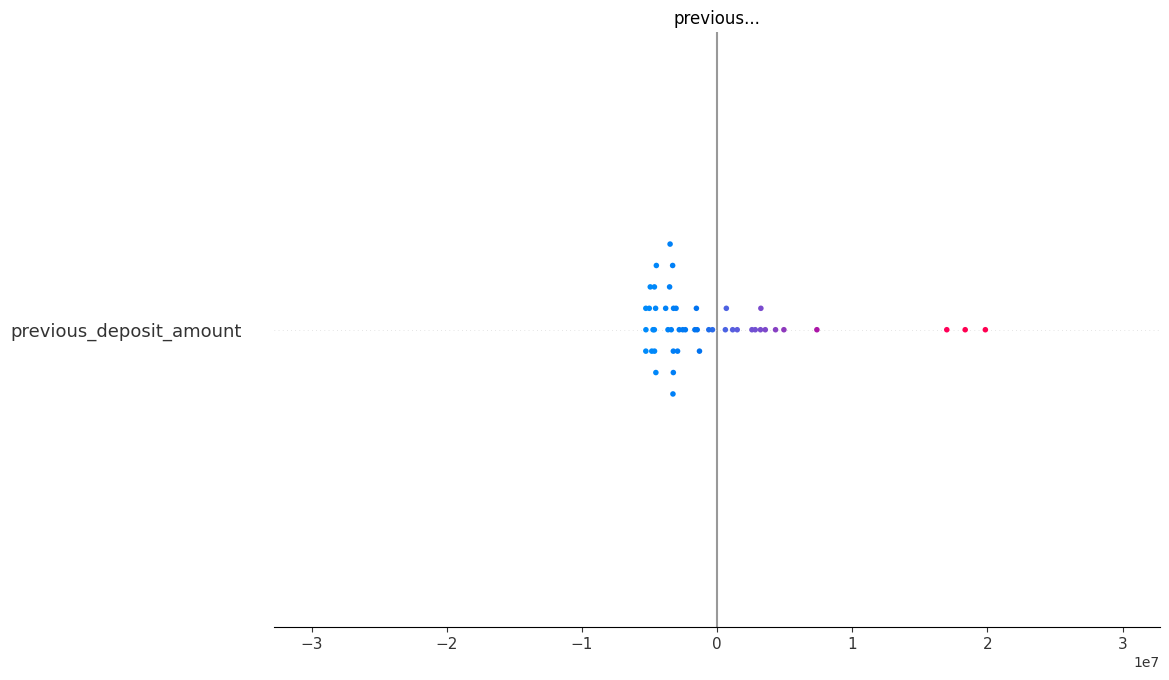

In [ ]:
# create KernelExplainer
explainer = shap.KernelExplainer(model.predict, X_train_np[:100])  # X_train_np is a sample of the training data
# calculate SHAP value
shap_values = explainer.shap_values(X_test_np[:50])
shap.summary_plot(shap_values, X_test_np[:50], feature_names=X_test.columns)

**Insights**  
previous_deposit_amount has relatively negative impact.  

# Random forest model

In [ ]:
#specifying features and targets
X = df[['previous_deposit_amount', 'previous_interest_rate', 'deposit_change', 'current_interest_rate', 'int_rate_change', 'revenue', 'expenses', 'investments', 'loan_repayment', 'net_cash_flow']]
y = df['balance_after_transaction']

#splitting training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model build and learning
rf_model = RandomForestRegressor(n_estimators=500, max_depth=7, random_state=42)
rf_model.fit(X_train, y_train)

# prediction
y_pred = rf_model.predict(X_test)

# evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

Root Mean Squared Error: 443151.89
R-squared: 0.9984


Text(0.5, 1.0, 'Feature Importance of Decision Tree')

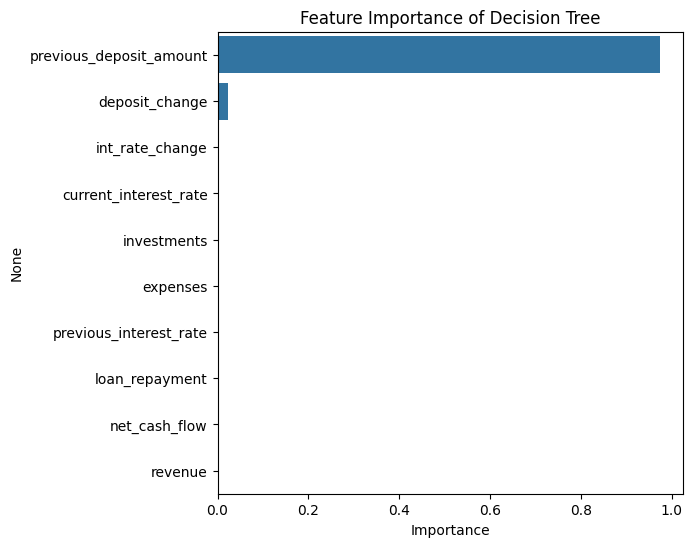

In [ ]:
importances = rf_model.feature_importances_
columns = X_train.columns
importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (6, 6))
sns.barplot(x=importance_df.Importance, y=importance_df.index)
plt.title("Feature Importance of Decision Tree")

**Insights**  
Since the dataset does not have trends, there are not specific feature importance founded. The model is overfitting and need to be improved.

📊 Insights from Random Forest Model Performance:  
The Random Forest model has been trained on the provided features to predict the balance after transaction (y) based on several financial factors (X). The following insights can be drawn from the evaluation of the model:  

📈 Model Evaluation Results:  
✅ Root Mean Squared Error (RMSE):  

RMSE=443,151.89  
The RMSE quantifies the average prediction error of the model. The RMSE of 443,151.89 means that, on average, the model's predictions deviate from the actual balance after transaction by approximately $443,152.  

☑️ R-squared (R²):  

R2 =0.9984  
The R² value of 0.9984 indicates that the model explains 99.84% of the variance in the target variable. This is an exceptionally high R² value, implying that the model is highly accurate in predicting the balance after transaction.  

📊 Key Insights:  
High Predictive Accuracy:  

The R² of 0.9984 suggests that the model fits the data very well and is able to explain almost all of the variability in the target variable. This indicates that the features used in the model are very effective in predicting the balance after transaction.  

Reasonable Error (RMSE):  

While the RMSE value seems high ($443,151.89), it's important to contextualize it based on the scale of the target variable, balance after transaction. If the balances are generally large amounts, then this error might be acceptable.
However, if the values ​​are smaller, further model refinement may be needed.  

Random Forest Strengths:  

Random Forest models are robust to overfitting, especially with a large number of trees (500 trees). This contributes to the model’s high R² value and helps ensure it generalizes well to unseen data.  

The model also benefits from being able to handle non-linear relationships between the features and the target, which is crucial in financial data where such relationships are common.  

🚀 Business Implications:  
Accurate Forecasting for Financial Institutions:  

The high R² value indicates that the model could be very useful for predicting future balances in financial systems, helping institutions make better liquidity and risk management decisions.  

Targeted Strategy Development:  

Understanding the key features driving the balance after transaction can help financial organizations refine their strategies in managing revenue, expenses, loans, and investments to optimize their financial outcomes.  

Scalable Application:  

The Random Forest model, with its robustness and high accuracy, could be deployed in a variety of real-world financial applications, including automated predictions of account balances, customer behavior analysis, and more.  

🎯 Conclusion:  
The Random Forest model demonstrates a high level of accuracy in predicting the balance after transaction, as evidenced by the high R² value. The high RMSE could be relatively due to the scale of the data, but the overall performance is strong. This model is highly suitable for forecasting financial metrics and could be a valuable tool for decision-making in financial institutions. Further improvements could come from hyperparameter tuning, feature engineering, and testing other ensemble techniques.  

# Gradient boost model

In [ ]:
# GBR build model
gbr_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# learning model
gbr_model.fit(X_train, y_train)

# prediction
y_pred = gbr_model.predict(X_test)

# evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")


Root Mean Squared Error: 272056.04
R-squared: 0.9994


Text(0.5, 1.0, 'Feature Importance of Gradient Boost')

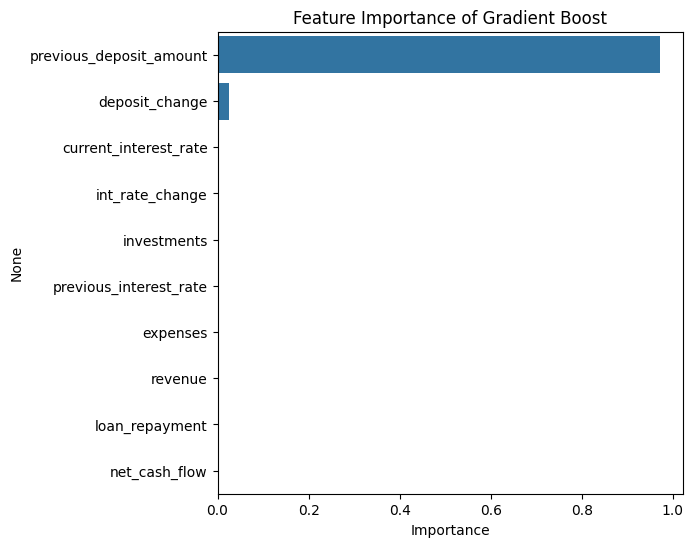

In [ ]:
importances = gbr_model.feature_importances_
columns = X_train.columns
importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (6, 6))
sns.barplot(x=importance_df.Importance, y=importance_df.index)
plt.title("Feature Importance of Gradient Boost")

**Insights**   
Since the dataset does not have trends, there are not specific feature importance founded.
The model is overfitting and need to be improved.

📊 Insights from Gradient Boosting Regressor Model Performance:  
The Gradient Boosting Regressor (GBR) model has been applied to predict the balance after transaction using the specified financial features. The following insights are drawn from the evaluation of the model's performance:  

📈 Model Evaluation Results:  
✅ Root Mean Squared Error (RMSE):  

RMSE=272,056.04  
The RMSE of 272,056.04 represents the average error in predicting the balance after transaction. This error is approximately $272,056 on average, indicating the level of deviation between the actual and predicted values.  

☑️ R-squared (R²):  
R2=0.9994  
The R² value of 0.9994 suggests that the model explains 99.94% of the variance in the target variable. This is an exceptionally high value, indicating that the model is highly effective in capturing the underlying patterns in the data and making accurate predictions.  

📊 Key Insights:  
Extremely High Predictive Accuracy:  

The R² value of 0.9994 is exceptionally close to 1, implying that the model has almost perfectly learned the relationship between the features and the target variable (balance after transaction). This is indicative of an almost flawless fit on the test data.  
  
Lower RMSE:  

The RMSE of 272,056.04 is lower compared to the Random Forest model's RMSE, suggesting that the GBR model is achieving a more accurate prediction with less error. However, the RMSE should be interpreted relative to the scale of the target variable.  

Gradient Boosting Model Strengths:  

Gradient Boosting works by iteratively refining predictions, making it particularly effective for capturing complex patterns and interactions within the data.  

The model’s high R² and relatively lower RMSE suggest that Gradient Boosting can better fine-tune the model's predictions compared to other models like Random Forest.  


🚀 Business Implications:  
Improved Predictive Power for Financial Forecasting:  

The high R² and low RMSE make this model very suitable for accurately predicting financial outcomes, such as the balance after transaction. This can support decision-making in financial institutions regarding cash flow management, deposit growth, and resource allocation.  

Actionable Insights for Strategic Planning:  

The model’s ability to predict future balances with such precision allows organizations to adjust their financial strategies, optimize revenue generation, reduce costs, and improve liquidity management.  

Operational Efficiency:  

With predictions of such high accuracy, organizations can automate parts of their forecasting processes, saving time and resources while improving operational efficiency.  

🎯 Conclusion:  
The Gradient Boosting Regressor model shows outstanding performance with an R² value of 0.9994, indicating that it explains nearly all of the variance in the target variable (balance after transaction). The RMSE of 272,056.04 is also relatively low, confirming the model’s predictive accuracy. This model is well-suited for financial forecasting tasks and can be leveraged to optimize decision-making in financial planning. Further improvements can be made through hyperparameter tuning and cross-validation to ensure robustness and generalizability across different datasets.  

# Lasso model

In [ ]:
#creating a Lasso Model (with Cross-Validation)
lasso_model = LassoCV(alphas=np.logspace(-3, 3, 50), cv=5, random_state=42)
lasso_model.fit(X_train, y_train)

#prediction
y_pred = lasso_model.predict(X_test)

#evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

#checking the coefficients
lasso_coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_model.coef_})
print(lasso_coef)


Root Mean Squared Error: 49217.66
R-squared: 1.0000
                   Feature  Coefficient
0  previous_deposit_amount         1.00
1   previous_interest_rate   -204572.09
2           deposit_change         1.00
3    current_interest_rate    205715.90
4          int_rate_change   -205259.56
5                  revenue        -0.10
6                 expenses         0.03
7              investments         0.24
8           loan_repayment         0.29
9            net_cash_flow         0.02


The LassoCV model demonstrates excellent performance with an R² of 1.0000 and a relatively low RMSE of 49,217.66, indicating high predictive accuracy for the balance after transaction. The feature coefficients reveal clear relationships with the target variable, particularly for previous deposit amounts and interest rates. However, the perfect fit suggests potential overfitting, and it would be valuable to further test the model on unseen data and explore additional regularization techniques.

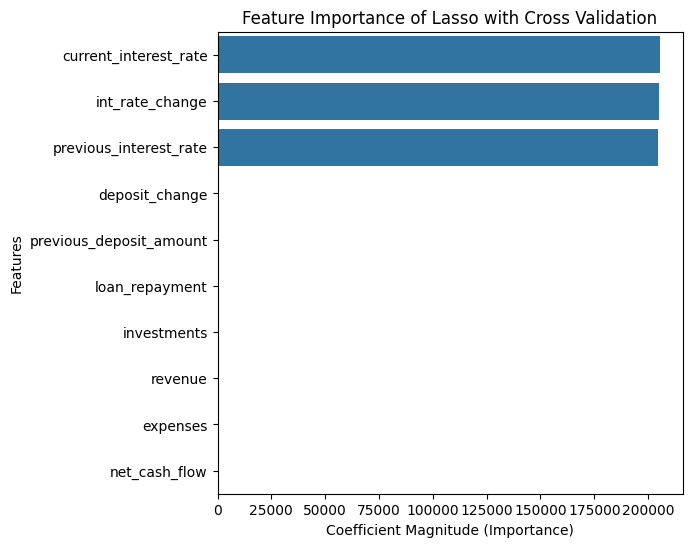

In [ ]:
#use coef_ instead of feature_importances_ in Lasso
importances = np.abs(lasso_model.coef_)  #use the absolute value of the coefficient as the importance measure
columns = X_train.columns

#sorting importance in a data frame
importance_df = pd.DataFrame(importances, index=columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

#visualization
plt.figure(figsize=(6, 6))
sns.barplot(x=importance_df.Importance, y=importance_df.index)
plt.title("Feature Importance of Lasso with Cross Validation")
plt.xlabel("Coefficient Magnitude (Importance)")
plt.ylabel("Features")
plt.show()

**Insights**  
Since the dataset does not have trends, there are not specific feature importance founded.
The model is overfitting and need to be improved.